In [1]:
!pip install pyjanitor pyvis --quiet

In [2]:
import pandas as pd
import janitor
import datetime

from IPython.core.display import display, HTML
from pyvis import network as net
import networkx as nx

In [3]:
df_ori = pd.read_csv("Connections.csv", skiprows=2)

In [4]:
df_ori.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1981 entries, 0 to 1980
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   First Name     1930 non-null   object
 1   Last Name      1930 non-null   object
 2   Email Address  61 non-null     object
 3   Company        1897 non-null   object
 4   Position       1898 non-null   object
 5   Connected On   1981 non-null   object
dtypes: object(6)
memory usage: 93.0+ KB


In [5]:
df = (
    df_ori
    .clean_names() # remove spacing and capitalization
    .drop(columns=['first_name', 'last_name', 'email_address']) # drop for privacy
    .dropna(subset=['company', 'position']) # drop missing values in company and position
    .to_datetime('connected_on', format='%d %b %Y')
  )
df.head()

,company,position,connected_on
0,Standard Chartered Bank,Director,2021-11-07
1,Khalda Petroleum Company (Apache),Completion and Well intervention Engineer,2021-11-05
2,Qatar Career Development Center,Career Development Officer,2021-11-02
3,Gojek,Data Scientist,2021-11-02
4,Apache Corporation,Lead Data Scientist,2021-11-02


### EDA

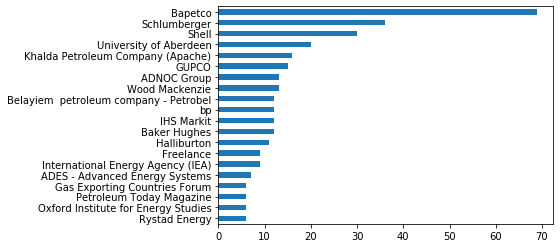

In [19]:
df['company'].value_counts().head(20).plot(kind="barh").invert_yaxis()

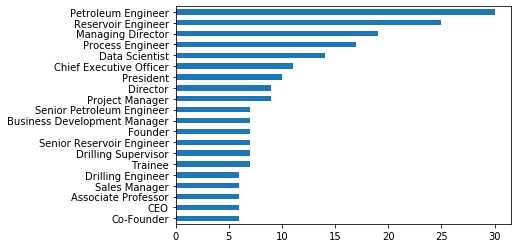

In [20]:
df['position'].value_counts().head(20).plot(kind="barh").invert_yaxis();

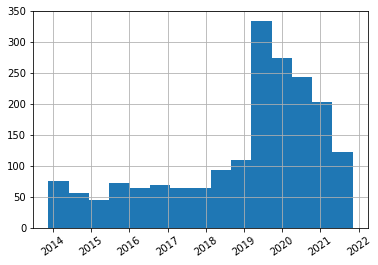

In [21]:
df['connected_on'].hist(xrot=35, bins=15);

### Aggregate sum of connections for companies

In [30]:
"""
df_company = df.groupby(['company'])['company'].count().to_frame()
df_company.reset_index()
df_company.columns = ['comp', 'count']

"""

"\ndf_company = df.groupby(['company'])['company'].count().to_frame()\ndf_company.reset_index()\ndf_company.columns = ['comp', 'count']\n\n"

In [31]:
df_company = df['company'].value_counts().reset_index()
df_company.columns = ['company', 'count']
df_company = df_company.sort_values(by="count", ascending=False)
df_company.head(10)

,company,count
0,Bapetco,69
1,Schlumberger,36
2,Shell,30
3,University of Aberdeen,20
4,Khalda Petroleum Company (Apache),16
5,GUPCO,15
6,ADNOC Group,13
7,Wood Mackenzie,13
8,Belayiem petroleum company - Petrobel,12
9,bp,12


### Aggregate sum of connections for positions

In [32]:
df_position = df['position'].value_counts().reset_index()
df_position.columns = ['position', 'count']
df_position = df_position.sort_values(by="count", ascending=False)
df_position.head(10)

,position,count
0,Petroleum Engineer,30
1,Reservoir Engineer,25
2,Managing Director,19
3,Process Engineer,17
4,Data Scientist,14
5,Chief Executive Officer,11
6,President,10
7,Director,9
8,Project Manager,9
13,Drilling Supervisor,7


## Creating the network

In [40]:

nt = net.Network(notebook=True)

g = nx.Graph()
g.add_node(0, label = "root") # intialize yourself as central node
g.add_node(1, label = "Company 1", size=10, title="info1")
g.add_node(2, label = "Company 2", size=40, title="info2")
g.add_node(3, label = "Company 3", size=60, title="info3")
g.add_edge(0, 1)
g.add_edge(0, 2)
g.add_edge(0, 3)

nt.from_nx(g)
nt.show('nodes.html')
display(HTML('nodes.html'))

In [41]:
print(f"number of nodes: {g.number_of_nodes()}")
print(f"number of edges: {g.number_of_edges()}")

number of nodes: 4
number of edges: 3


In [42]:
for _, row in df_company.head(5).iterrows():
    print(row['company'] + "-" + str(row['count']))

Bapetco-69
Schlumberger-36
Shell-30
University of Aberdeen-20
Khalda Petroleum Company (Apache)-16


In [43]:
print(df_company.shape)
df_company_reduced = df_company.loc[df_company['count']>=5]
print(df_company_reduced.shape)

(1366, 2)
(32, 2)


In [44]:
print(df_position.shape)
df_position_reduced = df_position.loc[df_position['count']>=5]
print(df_position_reduced.shape)

(1507, 2)
(29, 2)


In [50]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_company_reduced.iterrows():

  # store company name and count
    company = row['company']
    count = row['count']

    title = f"<b>{company}</b> – {count}"
    positions = set([x for x in df[company == df['company']]['position']])
    positions = ''.join('<li>{}</li>'.format(x) for x in positions)

    position_list = f"<ul>{positions}</ul>"
    hover_info = title + position_list

    g.add_node(company, size=count*2, title=hover_info, color='#3449eb')
    g.add_edge('root', company, color='grey')

# generate the graph
nt = net.Network(height='900px', width='1200px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('company_graph.html')
display(HTML('company_graph.html'))

In [39]:
# initialize graph
g = nx.Graph()
g.add_node('root') # intialize yourself as central

# use iterrows tp iterate through the data frame
for _, row in df_position_reduced.iterrows():

    count = f"{row['count']}"
    position= row['position']
  
    g.add_node(position, size=count, color='#3449eb', title=count)
    g.add_edge('root', position, color='grey')

# generate the graph
nt = net.Network(height='700px', width='700px', bgcolor="black", font_color='white')
nt.from_nx(g)
nt.hrepulsion()
# more customization https://tinyurl.com/yf5lvvdm
nt.show('position_graph.html')
display(HTML('position_graph.html'))